# Influx

In [1]:
import influxdb_client
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
import json

os.chdir('../')
print(os.getcwd())

from run import influx_cfg
print(influx_cfg.bucket)

/Volumes/external_drive/Code/MV2/Demo
modicumdb


In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [3]:
client = influxdb_client.InfluxDBClient(
    url=influx_cfg.url,
    token=influx_cfg.token,
    org=influx_cfg.org,
    retries=3
)

query_api = client.query_api()

In [11]:
dfs = query_api.query_data_frame('from(bucket:"modicumdb") '
                                 '|> range(start: -36h) '
                                 '|> filter(fn: (r) => r._measurement == "Events")')
df = pd.concat(dfs, ignore_index=True)
df = df.sort_values(by=['_time'], ascending=True)
first_time = df.iloc[0]['_time']
df['time_ms'] = df['_time'].apply(lambda x: (x - first_time).total_seconds() * 1000)
df = df[['time_ms', '_measurement', '_field', '_value', 'uuid', '_time']]
#df['offer_num'] = df['uuid'].apply(lambda x: int(x.split("_")[-1]))
df['entity'] = df['uuid'].apply(lambda x: x.split("_")[0])
#df['entity_id'] = df['uuid'].apply(lambda x: x.split("_")[1])
print(f"length of df: {len(df)}")
print(f"Unique _measurement: {df['_measurement'].unique()}")
print(f"Unique _field: {df['_field'].unique()}")
df.head(1)

length of df: 1322
Unique _measurement: ['Events']
Unique _field: ['state' 'sender' 'allocation']


,time_ms,_measurement,_field,_value,uuid,_time,entity
785,0.0,Events,state,1,supplier_978c7a496492499c8632e3e423bee8a2_offer_0,2021-11-20 18:58:06.465628+00:00,supplier


In [12]:
file_path = os.path.join(os.getcwd(), "demo_results", "raw_influx", "20-10-lazy.csv")
df.to_csv(file_path, index=False)

In [10]:
state = df[df['_field']=='state']
completed_uuids = state[state['_value']==11]['uuid'].unique().tolist()
print(len(completed_uuids))
sender = df[df['_field']=='sender']
allocation = df[df['_field']=='allocation']
state.head(2)

40


,time_ms,_measurement,_field,_value,uuid,_time,entity
527,0.000,Events,state,1,supplier_978c7a496492499c8632e3e423bee8a2_offer_0,2021-11-20 18:58:06.465628+00:00,supplier
831,2.939,Events,state,1,customer_9f60568f562b4437836833eb94284607_offer_0,2021-11-20 18:58:06.468567+00:00,customer


# Pulsar

In [12]:
#import pulsar
import requests
import prestodb
import pandas as pd

In [4]:
url = "pulsar://34.139.254.218:6650"
admin_url = "http://34.139.254.218:80/admin/v2"
presto_host = "34.139.254.218"
presto_port = 8081
tenant = "public"
namespace = "default"

In [6]:
request = f"{admin_url}/tenants"
print(request)
r = requests.get(request)
r.json()

http://34.139.254.218:80/admin/v2/tenants


['customer_019d86c542dd49c5a8701facebfdeeec_offer_0',
 'customer_02654232d9014521baa848ee6bd95f62_offer_0',
 'customer_02c2db674c1e40e6b69d635cc0760d80_offer_0',
 'customer_055546878d154f98a3e9077956cfcc70_offer_0',
 'customer_06a068ff8c7e4540ba47aae84b7a0334_offer_0',
 'customer_071859f31e924313bd462ebd63efc129_offer_0',
 'customer_07ec8b82c2234b9db4c45edcc05a43fd_offer_0',
 'customer_0aa9a012411e499cacaa241e432403c7_offer_0',
 'customer_0d62413d506a4e889fec17b1385027d2_offer_0',
 'customer_14051782af6341ba87f0080349d4adc8_offer_0',
 'customer_1521666b00cf4ac6b10b6c18354efb4c_offer_0',
 'customer_173a20b39ac14efdaca8351642877aab_offer_0',
 'customer_18a6df1451b946b2ae1811a69f2adb31_offer_0',
 'customer_18e24148e4334c1da241b9a868028f20_offer_0',
 'customer_1c5d271225b840c388834461cd8204b0_offer_0',
 'customer_1db76d0d62204a628f09fd494d69e326_offer_0',
 'customer_2018422e3635406fb7a2682844c2facf_offer_0',
 'customer_204ff94375e34fb0ac9d10d6ad994308_offer_0',
 'customer_21478287fdaa4c3eb

In [8]:
request = f"{admin_url}/namespaces/public"
print(request)
r = requests.get(request)
r.json()

http://34.139.254.218:80/admin/v2/namespaces/public


['public/default',
 'public/functions',
 'public/market_1',
 'public/market_2',
 'public/market_3',
 'public/market_5',
 'public/market_6',
 'public/market_7',
 'public/market_8']

In [9]:
request = f"{admin_url}/namespaces/customer_019d86c542dd49c5a8701facebfdeeec_offer_0"
print(request)
r = requests.get(request)
r.json()

http://34.139.254.218:80/admin/v2/namespaces/customer_019d86c542dd49c5a8701facebfdeeec_offer_0


['customer_019d86c542dd49c5a8701facebfdeeec_offer_0/market_6']

In [23]:
request = f"{admin_url}/persistent/customer_019d86c542dd49c5a8701facebfdeeec_offer_0/market_6"
print(request)
r = requests.get(request)
r.json()

http://34.139.254.218:80/admin/v2/persistent/customer_019d86c542dd49c5a8701facebfdeeec_offer_0/market_6


['persistent://customer_019d86c542dd49c5a8701facebfdeeec_offer_0/market_6/app_allocation_10',
 'persistent://customer_019d86c542dd49c5a8701facebfdeeec_offer_0/market_6/checklist_allocation_10',
 'persistent://customer_019d86c542dd49c5a8701facebfdeeec_offer_0/market_6/cleanup_allocation_10',
 'persistent://customer_019d86c542dd49c5a8701facebfdeeec_offer_0/market_6/input_allocation_10',
 'persistent://customer_019d86c542dd49c5a8701facebfdeeec_offer_0/market_6/output_allocation_10']

In [24]:
request = f"{admin_url}/persistent/customer_019d86c542dd49c5a8701facebfdeeec_offer_0/market_6/input_allocation_10/internalStats"
print(request)
r = requests.get(request)
r.json()

http://34.139.254.218:80/admin/v2/persistent/customer_019d86c542dd49c5a8701facebfdeeec_offer_0/market_6/input_allocation_10/internalStats


{'entriesAddedCounter': 51,
 'numberOfEntries': 0,
 'totalSize': 0,
 'currentLedgerEntries': 0,
 'currentLedgerSize': 0,
 'lastLedgerCreatedTimestamp': '2021-11-20T07:30:35.619Z',
 'waitingCursorsCount': 2,
 'pendingAddEntriesCount': 0,
 'lastConfirmedEntry': '2860:50',
 'state': 'LedgerOpened',
 'ledgers': [{'ledgerId': 4140,
   'entries': 0,
   'size': 0,
   'offloaded': False,
   'underReplicated': False}],
 'cursors': {'reader-91eefdde55': {'markDeletePosition': '2860:-1',
   'readPosition': '4140:0',
   'waitingReadOp': True,
   'pendingReadOps': 0,
   'messagesConsumedCounter': 0,
   'cursorLedger': -1,
   'cursorLedgerLastEntry': -1,
   'individuallyDeletedMessages': '[]',
   'lastLedgerSwitchTimestamp': '2021-11-20T18:21:57.486Z',
   'state': 'Uninitialized',
   'numberOfEntriesSinceFirstNotAckedMessage': 1,
   'totalNonContiguousDeletedMessagesRange': 0,
   'properties': {}},
  'supplier_f4b3f8bb546a4d10866144bbbe5ab5e9-input_allocation_10': {'markDeletePosition': '2860:50',
 

2021-11-20 12:31:23.589 INFO  [0x70001205b000] ConsumerStatsImpl:70 | Consumer [persistent://customer_019d86c542dd49c5a8701facebfdeeec_offer_0/market_6/app_allocation_10, reader-fc43190516, 0] , ConsumerStatsImpl (numBytesRecieved_ = 0, totalNumBytesRecieved_ = 0, receivedMsgMap_ = {}, ackedMsgMap_ = {}, totalReceivedMsgMap_ = {}, totalAckedMsgMap_ = {})
2021-11-20 12:31:57.393 INFO  [0x70001205b000] ConsumerStatsImpl:70 | Consumer [persistent://customer_019d86c542dd49c5a8701facebfdeeec_offer_0/market_6/input_allocation_10, reader-91eefdde55, 1] , ConsumerStatsImpl (numBytesRecieved_ = 0, totalNumBytesRecieved_ = 0, receivedMsgMap_ = {[Key: TimeOut, Value: 2610], }, ackedMsgMap_ = {}, totalReceivedMsgMap_ = {[Key: TimeOut, Value: 2610], }, totalAckedMsgMap_ = {})


In [33]:
import pulsar

In [29]:
import schema

In [34]:
client = pulsar.Client(url)

In [38]:
tenant = 'customer_019d86c542dd49c5a8701facebfdeeec_offer_0'
namespace = 'market_6'
topic = 'input_allocation_10'

#reader = client.create_reader(f"persistent://{tenant}/{namespace}{topic}", pulsar.MessageId.earliest)
reader = client.create_reader('persistent://customer_019d86c542dd49c5a8701facebfdeeec_offer_0/market_6/input_allocation_10', pulsar.MessageId.earliest, schema=pulsar.schema.AvroSchema(schema.InputDataSchema))



TypeError: create_reader() got an unexpected keyword argument 'initial_position'

In [40]:
consumer = client.subscribe('persistent://customer_019d86c542dd49c5a8701facebfdeeec_offer_0/market_6/input_allocation_10', subscription_name='testread', initial_position=pulsar.InitialPosition.Earliest, schema=pulsar.schema.AvroSchema(schema.InputDataSchema))


2021-11-20 12:48:08.930 INFO  [0x10ccb8e00] Client:88 | Subscribing on Topic :persistent://customer_019d86c542dd49c5a8701facebfdeeec_offer_0/market_6/input_allocation_10
2021-11-20 12:48:08.976 INFO  [0x7000121e4000] HandlerBase:54 | [persistent://customer_019d86c542dd49c5a8701facebfdeeec_offer_0/market_6/input_allocation_10, testread, 1] Getting connection from pool
2021-11-20 12:48:09.095 INFO  [0x7000121e4000] ConsumerImpl:220 | [persistent://customer_019d86c542dd49c5a8701facebfdeeec_offer_0/market_6/input_allocation_10, testread, 1] Created consumer on broker [10.0.0.166:53409 -> 34.139.254.218:6650] 


In [ ]:
while True:
    msg = consumer.receive()
    try:
        print("Received message '{}' id='{}'".format(msg.data(), msg.message_id()))
        # Acknowledge successful processing of the message
        consumer.acknowledge(msg)
    except:
        # Message failed to be processed
        consumer.negative_acknowledge(msg)

In [36]:
reader.has_message_available()

2021-11-20 12:40:50.619 WARN  [0x7000121e4000] ClientConnection:971 | [10.0.0.166:53409 -> 34.139.254.218:6650] Received error response from server: BrokerMetadataError -- req_id: 1


Exception: Pulsar error: BrokerMetadataError

In [37]:
results = []
while True:
    msg = reader.read_next()
    results.append(msg.data())
    print("Received message '{}' id='{}'".format(msg.data(), msg.message_id()))

2021-11-20 12:41:23.593 INFO  [0x70001205b000] ConsumerStatsImpl:70 | Consumer [persistent://customer_019d86c542dd49c5a8701facebfdeeec_offer_0/market_6/app_allocation_10, reader-fc43190516, 0] , ConsumerStatsImpl (numBytesRecieved_ = 0, totalNumBytesRecieved_ = 0, receivedMsgMap_ = {}, ackedMsgMap_ = {}, totalReceivedMsgMap_ = {}, totalAckedMsgMap_ = {})


SystemError: 

In [14]:
def presto_query(query, user='test', catalog='pulsar', schema='public/default', host='34.139.254.218', port=8081):
    conn = prestodb.dbapi.connect(
        host=host,
        port=port,
        user=user,
        catalog=catalog,
        schema=schema)
    cur = conn.cursor()
    cur.execute(query)
    data = cur.fetchall()
    columns = cur.description
    df = pd.DataFrame(data)
    df.columns = [x[0] for x in columns]
    return df.replace('', np.nan)

query = "SELECT * FROM input_allocation_10"
schema = "customer_019d86c542dd49c5a8701facebfdeeec_offer_0/market_6"
df = presto_query(query, schema)

ConnectTimeout: HTTPConnectionPool(host='34.139.254.218', port=8081): Max retries exceeded with url: /v1/statement (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x115daf6d0>, 'Connection to 34.139.254.218 timed out. (connect timeout=30.0)'))

In [ ]:
GET /admin/v2/:schema/:tenant/:namespace

# Figure 1

In [123]:
def load_raw_results():
    dfs = []
    results_dir = os.path.join(os.getcwd(), "demo_results", "raw_influx")
    onlyfiles = [f for f in os.listdir(results_dir) if os.path.isfile(os.path.join(results_dir, f))]
    file_names = [f for f in onlyfiles if f.endswith(".csv")]
    for file_name in file_names:
        file_path = os.path.join(results_dir, file_name)
        df = pd.read_csv(file_path)
        temp = file_name.split("-")
        df['num_customers'] = int(temp[0])
        df['num_suppliers'] = int(temp[1])
        df['supplier_behavior'] = temp[2].split(".")[0]
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

df = load_raw_results()
state = df[df['_field']=='state']
sender = df[df['_field']=='sender']
allocation = df[df['_field']=='allocation']
state.head(2)

,time_ms,_measurement,_field,_value,uuid,entity,num_customers,num_suppliers,supplier_behavior
1,0.000,Events,state,1,mediator_1_offer_0,mediator,10,10,lazy
2,1356.173,Events,state,1,customer_da12336d62e44f7aba5e2bea5e9f222a_offer_0,customer,10,10,lazy


In [136]:
def plot_state(raw_state, num_customers, num_suppliers, supplier_behavior):
    state = deepcopy(raw_state)
    state = state[(state['num_customers']==num_customers) & (state['num_suppliers']==num_suppliers) & (state['supplier_behavior']==supplier_behavior) & (state['entity'].isin(['customer', 'supplier']))]
    completed_uuids = state[state['_value']=='11']['uuid'].unique().tolist()
    print(f"Number of completed uuids: {len(completed_uuids)}")
    state = state[state['uuid'].isin(completed_uuids)]
    
    print(len(state))
    result = {'state_id': [], 'state': [], 'entity': [], 'uuid': [], 'time (s)': [], 'time (ms)': []}
    #state_pairs = [[1,2], [2,3], [3,4], [4,5], [6,7], [7,11]]
    state_pairs = [[1,4], [4,5], [7,11]]
    state_names = ['a', 'b', 'c']
    for uuid in state['uuid'].unique():
        i = 0
        for state_pair in state_pairs:
            start_time = state.loc[(state['uuid']==uuid) & (state['_value']==str(state_pair[0])), 'time_ms'].iloc[0]
            end_time = state.loc[(state['uuid']==uuid) & (state['_value']==str(state_pair[1])), 'time_ms'].iloc[0]
            time_diff = end_time - start_time
            result['state_id'].append(f"{state_pair[0]}")
            result['state'].append(state_names[i])
            result['entity'].append(f"{uuid.split('_')[0]}")
            result['uuid'].append(uuid)
            result['time (s)'].append(time_diff/1000)
            result['time (ms)'].append(time_diff)
            i += 1
    df_plot = pd.DataFrame(result)
    return df_plot
    

Number of completed uuids: 20
160


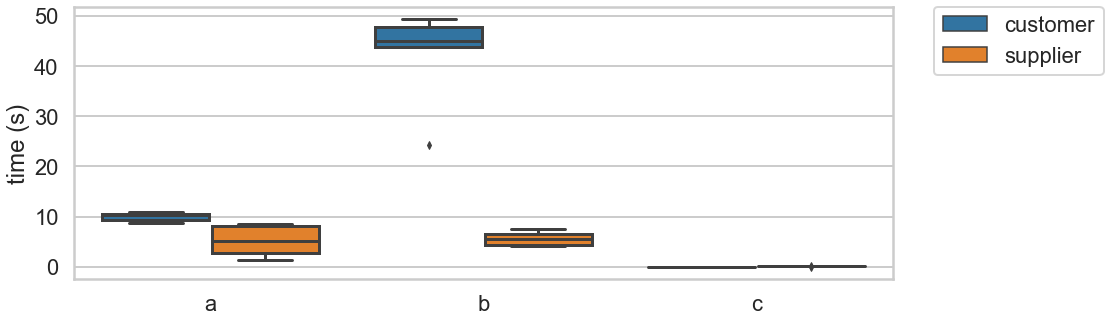

In [140]:
# 10-10-nominal

df_plot = plot_state(state, 10, 10, "nominal")
sns.set_style("whitegrid")
sns.set_context("poster")
f, ax = plt.subplots(figsize=(16, 5))
sns.boxplot(data=df_plot, x="state", y="time (s)", hue="entity")
ax.set(xlabel=None)
#ax.set(ylim=(20, None))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
file_path = os.path.join(os.getcwd(), "demo_results", "img", "10-10-nominal.pdf")
plt.savefig(file_path, dpi=300)
plt.show()

Number of completed uuids: 20
220


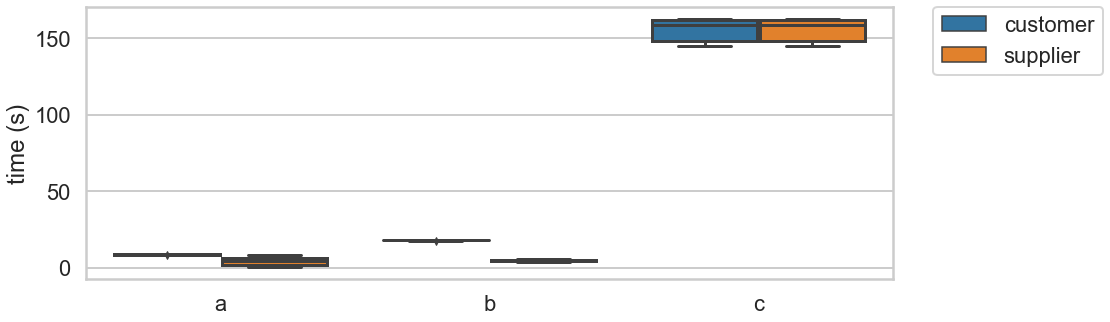

In [141]:
# 10-10-lazy

df_plot = plot_state(state, 10, 10, "lazy")
sns.set_style("whitegrid")
sns.set_context("poster")
f, ax = plt.subplots(figsize=(16, 5))
sns.boxplot(data=df_plot, x="state", y="time (s)", hue="entity")
ax.set(xlabel=None)
#ax.set(ylim=(20, None))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
file_path = os.path.join(os.getcwd(), "demo_results", "img", "10-10-lazy.pdf")
plt.savefig(file_path, dpi=300)
plt.show()

# Resource Consumption

SELECT * FROM `ascendant-choir-331619.modicummarket11192021.gke_cluster_resource_consumption`

SELECT * FROM `ascendant-choir-331619.modicummarket11192021.gke_cluster_resource_usage`

https://cloud.google.com/kubernetes-engine/docs/how-to/cluster-usage-metering#view_in_bigquery

In [64]:
#file_path = os.path.join(os.getcwd(), "demo_results", "resource", "resource_usage.csv")
file_path = os.path.join(os.getcwd(), "demo_results", "resource", "resource_consumption.csv")
usage = pd.read_csv(file_path)
usage.head(1)

,cluster_location,cluster_name,namespace,resource_name,sku_id,start_time,end_time,fraction,cloud_resource_size,labels,project,usage
0,us-central1-c,cost-optimized-cluster-1,kube-system,memory,F449-33EC-A5EF,2021-11-18T08:08:56Z,2021-11-18T09:08:57Z,0.00218,4128378880,"{\n ""labels"": [{\n ""key"": ""pod-template-ge...","{\n ""project"": {\n ""id"": ""ascendant-choir-...","{\n ""usage"": {\n ""amount"": ""32410828800.0""..."


In [65]:
usage['start_time'] = pd.to_datetime(usage['start_time'])
usage['end_time'] = pd.to_datetime(usage['end_time'])

service = []
usage_val = []
usage_unit = []
for k, v in usage.iterrows():
    temp = json.loads(v['labels'])['labels']
    temp2 = {x['key']: x['value'] for x in temp}
    if 'io.kompose.service' in temp2.keys():
        service.append(temp2['io.kompose.service'])
    else:
        service.append('none')
    temp3 = json.loads(v['usage'])['usage']
    usage_val.append(float(temp3['amount']))
    usage_unit.append(temp3['unit'])

usage['service'] = service
usage['usage_val'] = usage_val
usage['usage_unit'] = usage_unit
usage.head(1)

,cluster_location,cluster_name,namespace,resource_name,sku_id,start_time,end_time,fraction,cloud_resource_size,labels,project,usage,service,usage_val,usage_unit
0,us-central1-c,cost-optimized-cluster-1,kube-system,memory,F449-33EC-A5EF,2021-11-18 08:08:56+00:00,2021-11-18 09:08:57+00:00,0.00218,4128378880,"{\n ""labels"": [{\n ""key"": ""pod-template-ge...","{\n ""project"": {\n ""id"": ""ascendant-choir-...","{\n ""usage"": {\n ""amount"": ""32410828800.0""...",none,3.241083e+10,byte-seconds


In [66]:
usage[usage['usage_val']>0]['labels'].unique()

array(['{\n  "labels": [{\n    "key": "pod-template-generation",\n    "value": "1"\n  }, {\n    "key": "controller-revision-hash",\n    "value": "686b756cd6"\n  }, {\n    "key": "k8s-app",\n    "value": "gcp-compute-persistent-disk-csi-driver"\n  }]\n}',
       '{\n  "labels": [{\n    "key": "pod-template-generation",\n    "value": "1"\n  }, {\n    "key": "component",\n    "value": "fluentbit-gke"\n  }, {\n    "key": "controller-revision-hash",\n    "value": "68c7599fd7"\n  }, {\n    "key": "k8s-app",\n    "value": "fluentbit-gke"\n  }, {\n    "key": "kubernetes.io/cluster-service",\n    "value": "true"\n  }]\n}',
       '{\n  "labels": [{\n    "key": "pod-template-generation",\n    "value": "1"\n  }, {\n    "key": "component",\n    "value": "gke-metrics-agent"\n  }, {\n    "key": "controller-revision-hash",\n    "value": "7955df8777"\n  }, {\n    "key": "k8s-app",\n    "value": "gke-metrics-agent"\n  }]\n}',
       '{\n  "labels": [{\n    "key": "k8s-app",\n    "value": "glbc"\n  }, {

In [67]:
usage['service'].unique()

array(['none', 'allocator-service', 'lazy-supplier', 'mediator-service',
       'sporadic-customer', 'verifier-service', 'nominal-supplier'],
      dtype=object)

In [69]:
temp = usage[usage['service']=='lazy-supplier']
temp.head()

,cluster_location,cluster_name,namespace,resource_name,sku_id,start_time,end_time,fraction,cloud_resource_size,labels,project,usage,service,usage_val,usage_unit
266,us-central1-c,cost-optimized-cluster-1,default,cpu,CF4E-A0C7-E3BF,2021-11-18 22:26:43+00:00,2021-11-18 23:26:47+00:00,0.000499,4,"{\n ""labels"": [{\n ""key"": ""io.kompose.netw...","{\n ""project"": {\n ""id"": ""ascendant-choir-...","{\n ""usage"": {\n ""amount"": ""7.199999999999...",lazy-supplier,7.200000e+00,seconds
267,us-central1-c,cost-optimized-cluster-1,default,memory,F449-33EC-A5EF,2021-11-18 22:26:43+00:00,2021-11-18 23:26:47+00:00,0.002398,16792662016,"{\n ""labels"": [{\n ""key"": ""io.kompose.serv...","{\n ""project"": {\n ""id"": ""ascendant-choir-...","{\n ""usage"": {\n ""amount"": ""145140940800.0...",lazy-supplier,1.451409e+11,byte-seconds
268,us-central1-c,cost-optimized-cluster-1,default,cpu,CF4E-A0C7-E3BF,2021-11-18 22:26:51+00:00,2021-11-18 23:26:58+00:00,0.000499,4,"{\n ""labels"": [{\n ""key"": ""io.kompose.netw...","{\n ""project"": {\n ""id"": ""ascendant-choir-...","{\n ""usage"": {\n ""amount"": ""7.199999999999...",lazy-supplier,7.200000e+00,seconds
269,us-central1-c,cost-optimized-cluster-1,default,memory,F449-33EC-A5EF,2021-11-18 22:26:51+00:00,2021-11-18 23:26:58+00:00,0.003019,16792662016,"{\n ""labels"": [{\n ""key"": ""io.kompose.netw...","{\n ""project"": {\n ""id"": ""ascendant-choir-...","{\n ""usage"": {\n ""amount"": ""182874931200.0...",lazy-supplier,1.828749e+11,byte-seconds
270,us-central1-c,cost-optimized-cluster-1,default,cpu,CF4E-A0C7-E3BF,2021-11-18 22:26:54+00:00,2021-11-18 23:26:55+00:00,0.000723,4,"{\n ""labels"": [{\n ""key"": ""io.kompose.netw...","{\n ""project"": {\n ""id"": ""ascendant-choir-...","{\n ""usage"": {\n ""amount"": ""10.40999999999...",lazy-supplier,1.041000e+01,seconds


In [ ]:
start_time = temp.iloc[0]['start_time']
end_time = temp.iloc[0]['end_time']

In [ ]:
usage['service']==''

In [46]:
temp = usage.iloc[0]['start_time']
print(temp)
pd.to_datetime(temp)

2021-11-18T19:27:22.239Z


Timestamp('2021-11-18 19:27:22.239000+0000', tz='UTC')

# Void

In [102]:
state_pairs = [[1,2], [2,3], [4,5], [6,7], [7,11]]
completed_uuids = state[state['_value']==11]['uuid'].unique().tolist()
print(len(completed_uuids))
state = state[state['uuid'].isin(completed_uuids)]
state.head()

20


,time_ms,_measurement,_field,_value,uuid,entity
626,1356.173,Events,state,1,customer_da12336d62e44f7aba5e2bea5e9f222a_offer_0,customer
627,1394.643,Events,state,2,customer_da12336d62e44f7aba5e2bea5e9f222a_offer_0,customer
85,1398.361,Events,state,1,customer_96995d93fe764243b989d1c4c7d9c2c9_offer_0,customer
325,1478.482,Events,state,1,customer_90df753fc3bf4eeda65998aeeb7a6329_offer_0,customer
680,1511.785,Events,state,1,customer_a422ec25e1504d07962f914c93bdd669_offer_0,customer


In [103]:
result = {'state_id': [], 'state': [], 'entity': [], 'uuid': [], 'time (s)': [], 'time (ms)': []}
#state_pairs = [[1,2], [2,3], [3,4], [4,5], [6,7], [7,11]]
state_pairs = [[1,4], [4,5], [6,11]]
state_names = ['a', 'b', 'c']
for uuid in state['uuid'].unique():
    i = 0
    for state_pair in state_pairs:
        start_time = state.loc[(state['uuid']==uuid) & (state['_value']==state_pair[0]), 'time_ms'].iloc[0]
        end_time = state.loc[(state['uuid']==uuid) & (state['_value']==state_pair[1]), 'time_ms'].iloc[0]
        time_diff = end_time - start_time
        result['state_id'].append(f"{state_pair[0]}")
        result['state'].append(state_names[i])
        result['entity'].append(f"{uuid.split('_')[0]}")
        result['uuid'].append(uuid)
        result['time (s)'].append(time_diff/1000)
        result['time (ms)'].append(time_diff)
        i += 1
df_plot = pd.DataFrame(result)
df_plot.head()

,state_id,state,entity,uuid,time (s),time (ms)
0,1,a,customer,customer_da12336d62e44f7aba5e2bea5e9f222a_offer_0,8.948597,8948.597
1,4,b,customer,customer_da12336d62e44f7aba5e2bea5e9f222a_offer_0,18.276254,18276.254
2,6,c,customer,customer_da12336d62e44f7aba5e2bea5e9f222a_offer_0,153.508270,153508.270
3,1,a,customer,customer_96995d93fe764243b989d1c4c7d9c2c9_offer_0,9.137890,9137.890
4,4,b,customer,customer_96995d93fe764243b989d1c4c7d9c2c9_offer_0,18.014055,18014.055


In [104]:
file_path = os.path.join(os.getcwd(), "demo_results", "stages", "10-10-lazy.csv")
df_plot.to_csv(file_path, index=False)

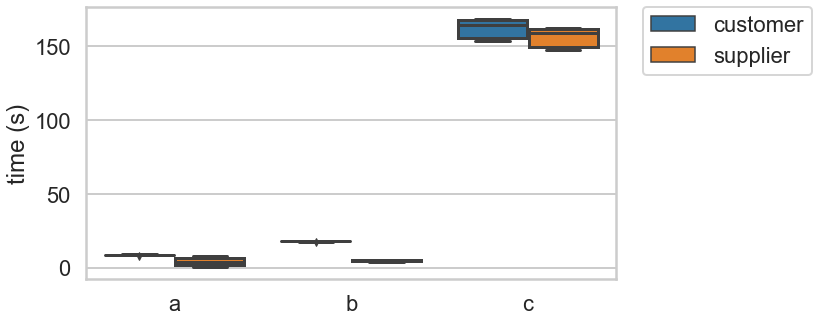

In [105]:
sns.set_style("whitegrid")
sns.set_context("poster")
f, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(data=df_plot, x="state", y="time (s)", hue="entity")
ax.set(xlabel=None)
#ax.set(ylim=(20, None))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
#file_path = os.path.join(os.getcwd(), "..", "data", "results", "img", "servicerate.pdf")
#plt.savefig(file_path, dpi=300)
plt.show()

In [39]:
client.close()

# Pulsar

In [98]:
print(1)

1
